### Objective
The goal is to implement a multilayer perceptron (MLP) character-level language model following the [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). 

### Take away 

In [38]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

### About the paper : 
- They build a word-level language model. 
- They have a vocabulary of 17000 possible words. 
- Every word is embadded in 30 dim space, in the beginning these words are initialized completely randomly so they're spread out at random. We tune these embeddings of these words using back propagation so during the course of training of this neural network these points or vectors are going to basically move around in this space. Words that have very simimarity meanings or that are indeed synonyms of each other might end up in a very similar part of the space and conversely words that mean very different things would go somewhere else in a space.

In [24]:
words = open('names.txt','r').read().splitlines()


In [25]:
chars = sorted(list(set('.'.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi[0]='.'
itos = {s:i for s,i in stoi.items()}

First, building the dataset. <br/>
Context length: how many characters do we take to predict the next one 

In [35]:

block_size = 3 
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
  
X = torch.tensor(X)
Y = torch.tensor(Y)



In [36]:
X.shape

torch.Size([36, 3])

In [42]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [43]:
# implemented the embadding lookup table 
C = torch.rand((27,2))
emb = C[X]
emb.shape

torch.Size([36, 3, 2])

In [44]:
Xtr.shape, Ytr.shape 

(torch.Size([182512, 3]), torch.Size([182512]))

In [45]:
g = torch.Generator().manual_seed(2147483647) 
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [46]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [50]:
lri = []
lossi = []
stepi = []

In [53]:
C.shape

torch.Size([27, 10])

In [55]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

IndexError: index 27 is out of bounds for dimension 0 with size 27

In [56]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

IndexError: index 27 is out of bounds for dimension 0 with size 27

KeyError: 1

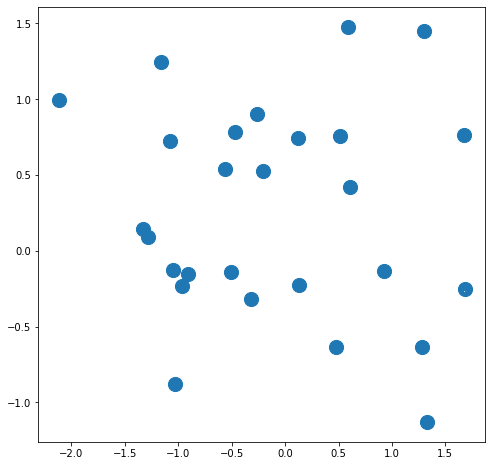

In [57]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [58]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [59]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

KeyError: 8